In [1]:
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd
import librosa
import librosa.display
import os
from os import path
import io
!pip3 install soundfile
!pip3 install librosa
import soundfile as sf
import librosa.feature

In [2]:
!pip install ipython-autotime

%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=9f8a69a350abc9c93c0527e75dafa0aeaacef4c4cda68ba7a820c37e3a276ee2
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


# Opening datasets

In [3]:
DIR = '/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class' 
DIR_AUDIO = DIR + '/soundfiles/TAU-urban-acoustic-scenes-2020-3class-development/'
df_meta = pd.read_csv(f'{DIR}/meta.csv')
df_meta = pd.read_csv(io.StringIO(df_meta.to_csv(index=False)))
df_meta.head()

,filename,scene_label,identifier
0,audio/airport-barcelona-0-0-a.wav,indoor,barcelona-0
1,audio/airport-barcelona-0-10-a.wav,indoor,barcelona-0
2,audio/airport-barcelona-0-11-a.wav,indoor,barcelona-0
3,audio/airport-barcelona-0-12-a.wav,indoor,barcelona-0
4,audio/airport-barcelona-0-13-a.wav,indoor,barcelona-0


time: 3.64 s


# Getting part of the dataset
Não coloquei 10% dele, pois poderiam vir mais datasets de um label específico. E nem coloquei 10% de cada label, pois a quantidades de datasets dentro de cada label é diferente. Então defini n datasets de cada label.

In [4]:
df = df_meta.groupby('scene_label', as_index=False).apply(lambda x: x.sample(n=10, random_state=15))
df.index = [i[1] for i in df.index]
df.head()

,filename,scene_label,identifier
3028,audio/metro_station-helsinki-231-6952-a.wav,indoor,helsinki-231
9493,audio/shopping_mall-milan-1183-45376-a.wav,indoor,milan-1183
4163,audio/metro_station-stockholm-85-2308-a.wav,indoor,stockholm-85
3224,audio/metro_station-lisbon-1020-42471-a.wav,indoor,lisbon-1020
9294,audio/shopping_mall-lyon-1066-42583-a.wav,indoor,lyon-1066


time: 24.1 ms


In [5]:
# so neste caso q n vamos usar transportation
df = df.loc[df['scene_label'] != 'transportation']

time: 1.9 ms


In [6]:
print(df.loc[df['scene_label'] == 'outdoor'].shape)
print(df.loc[df['scene_label'] == 'indoor'].shape)
print(df.loc[df['scene_label'] == 'transportation'].shape)

(10, 3)
(10, 3)
(0, 3)
time: 3.81 ms


Reading the datasets and storing it to 'signals'

In [7]:
info_sound = df[['filename','scene_label']].to_numpy()
LABELS = ['indoor', 'outdoor']

time: 2.46 ms


In [8]:
dic_signals = {x:[] for i, x in enumerate(LABELS)}

for filename, label in info_sound:
    if(path.isfile(os.path.join(DIR_AUDIO, filename))):
        dic_signals[label].append(sf.read(os.path.join(DIR_AUDIO, filename)))

time: 1min 33s


Labels:


0.   Indoor
1.   Outdoor
2.   Transportation



# Getting Features

1.   Centroid Mean
2.   Centroid STD
3.   Flatness Mean
4.   Flatness STD
5.   RMS



In [159]:
PARTS = 10
def get_features(dic_signals)->pd.DataFrame:
    # LUANA - FEATURES
    def get_centroid(S, sr):
        return librosa.feature.spectral_centroid(S=S, sr=sr)
    def get_flatness(S):
        return librosa.feature.spectral_flatness(S=S)
    def get_rms(S):
        return librosa.feature.rms(S=S)
    def get_mfccs(S, sr):
        return librosa.feature.mfcc(S=S, sr=sr)

    feats = (np.zeros((1,8))[0])
    
    j = 1
    k = 0 #label
    for label, signals in dic_signals.items():
        for signal, samplerate in signals:
            music_features = []
            signal = signal[:,0]
            #print(len(signal))
            mel = librosa.feature.melspectrogram(y=signal,sr=samplerate, hop_length=512)
            mel = np.asarray(mel)
            #print(mel.shape)
            i = 1
            for banda in np.array_split(mel, 16):
                #print(banda.shape)
                for second in np.array_split(banda, 10, axis=1):
                    #print(np.array(second).shape)
                    c = get_centroid(second, samplerate)
                    f = get_flatness(second)
                    r = get_rms(second)
                    MUSIC_FEATURES = np.array([np.mean(c),np.std(c),np.mean(f), np.std(f), r[0][0],k, i, j])
                    feats = np.vstack([feats, MUSIC_FEATURES])
                i += 1
            j += 1
        k += 1
    return pd.DataFrame(data=feats).drop(0).reset_index(drop=True)
        


time: 25.6 ms


In [160]:
df = get_features(dic_signals)

time: 2.21 s


In [161]:
df.to_csv("/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class/features.csv")

time: 51.2 ms


In [162]:
df = pd.read_csv("/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class/features.csv").drop("Unnamed: 0",axis=1) 

time: 12.6 ms


In [163]:
df.head(161)

,0,1,2,3,4,5,6,7
0,7481.670496,2679.483007,0.237261,1.551694e-01,7.913587e-02,0.0,1.0,1.0
1,8057.025757,2742.280972,0.274667,1.717078e-01,8.141728e-02,0.0,1.0,1.0
2,9491.011620,3737.712066,0.266964,1.838616e-01,2.568669e-02,0.0,1.0,1.0
3,7104.160579,2824.953579,0.197265,1.580038e-01,8.259817e-02,0.0,1.0,1.0
4,8214.010642,2856.016520,0.278010,1.766982e-01,5.686449e-02,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...
156,9956.240747,1515.482652,1.000000,2.220446e-16,2.290304e-08,0.0,16.0,1.0
157,10653.785500,1381.089323,1.000000,2.220446e-16,6.081612e-08,0.0,16.0,1.0
158,9920.765103,2310.315744,0.972540,1.504634e-01,1.372053e-07,0.0,16.0,1.0
159,9992.098476,1674.116902,1.000000,2.220446e-16,2.640072e-08,0.0,16.0,1.0


time: 29.9 ms


In [88]:
from sklearn.model_selection import GroupShuffleSplit

time: 849 µs


Split no dataframe baseado em grupos do número da música

In [164]:
train_inds, test_inds = next(GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 2).split(df, groups=df['7']))

time: 3.6 ms


In [165]:
train_inds

array([ 160,  161,  162, ..., 2557, 2558, 2559])

time: 2.31 ms


In [166]:
test_inds

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
         44,   45,   46,   47,   48,   49,   50,   51,   52,   53,   54,
         55,   56,   57,   58,   59,   60,   61,   62,   63,   64,   65,
         66,   67,   68,   69,   70,   71,   72,   73,   74,   75,   76,
         77,   78,   79,   80,   81,   82,   83,   84,   85,   86,   87,
         88,   89,   90,   91,   92,   93,   94,   95,   96,   97,   98,
         99,  100,  101,  102,  103,  104,  105,  106,  107,  108,  109,
        110,  111,  112,  113,  114,  115,  116,  117,  118,  119,  120,
        121,  122,  123,  124,  125,  126,  127,  128,  129,  130,  131,
        132,  133,  134,  135,  136,  137,  138,  139,  140,  141,  142,
        143,  144,  145,  146,  147,  148,  149,  1

time: 4.65 ms


In [167]:
X_train = (df.iloc[train_inds, 0:-3])
X_test = (df.iloc[test_inds,0:-3])
y_train = (df.iloc[train_inds,[5,6,7]]).values
y_test = (df.iloc[test_inds,[5,6,7]]).values

time: 7.38 ms


In [168]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1920, 5), (640, 5), (1920, 3), (640, 3))

time: 4.87 ms


In [96]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

time: 919 µs


In [97]:
scaler.fit(X_train.values)
X_train = scaler.transform(X_train.values)
X_test = scaler.transform(X_test.values)

time: 2.9 ms


In [98]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

time: 847 µs


# Building a KNN Model

In [99]:
def get_k_accuracy(X_train, X_test, y_train, y_test): 
    def knn_classifier(k, X_train, X_test, y_train, y_test):
        #print(y_train)
        knn = KNeighborsClassifier(n_neighbors = k)
        knn.fit(X_train,y_train)
        y_pred = knn.predict(X_test)
        #print(y_pred)
        return metrics.accuracy_score(y_test,y_pred)

    def plot_scores(x,y):
        fig, a = plt.subplots(1, figsize = (10, 8))
        title = "Accuracy Score by K values"
        plt.title(title)
        plt.xlabel('Value of K for KNN')
        plt.ylabel('Testing Accuracy')
        a.plot(x, y)

    k_range = range(1,15)
    scores = {}
    scores_list = []

    for k in k_range:
        scores[k] = knn_classifier(k, X_train, X_test, y_train, y_test)
        scores_list.append(scores[k])

    plot_scores(list(k_range), scores_list)
    print('Accuracy: ' + str(scores[max(scores, key= scores.get)]))
    return max(scores, key= scores.get)



time: 13.9 ms


Accuracy: 0.590625


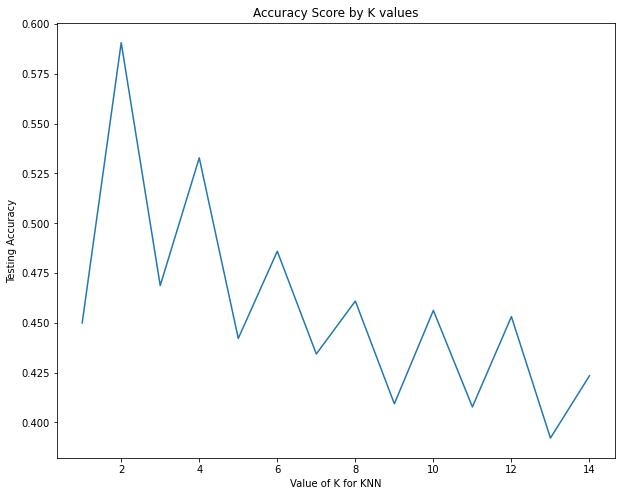

time: 529 ms


In [169]:
k = get_k_accuracy(X_train,X_test, y_train[:,0], y_test[:,0])
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train,y_train[:,0])
y_pred = knn.predict(X_test)

In [103]:
from collections import Counter

time: 743 µs


Contagem das predições para cada música

In [170]:
(y_test, y_pred)

(array([[ 0.,  1.,  1.],
        [ 0.,  1.,  1.],
        [ 0.,  1.,  1.],
        ...,
        [ 1., 16., 13.],
        [ 1., 16., 13.],
        [ 1., 16., 13.]]),
 array([0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
        0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1.,
        0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0.,
        1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0.,
        1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.,

time: 8.26 ms


In [183]:
np.unique(y_test[:,2])

array([ 1.,  5.,  6., 13.])

time: 5.48 ms


In [173]:
counts = dict()
for id in np.unique(y_test[:,2]):
    counts[id] = []
print(counts)
for t, p in zip(y_test, y_pred):
    counts[t[2]].append(p)

counter = [Counter(y) for x,y in counts.items()]
counter

{1.0: [], 5.0: [], 6.0: [], 13.0: []}


[Counter({0.0: 106, 1.0: 54}),
 Counter({0.0: 107, 1.0: 53}),
 Counter({0.0: 103, 1.0: 57}),
 Counter({0.0: 98, 1.0: 62})]

time: 6.75 ms


Votação das predições

In [198]:
music_y_pred = [max(x, key=x.get) for x in counter]
music_y_test = [[x,z] for x,y,z in y_test]
music_y_test = np.unique(music_y_test, axis=0)[:,0]

time: 6.58 ms


In [199]:
music_y_test

array([0., 0., 0., 1.])

time: 2.49 ms


In [200]:
metrics.accuracy_score(music_y_test,music_y_pred)

0.75

time: 2.93 ms


In [201]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(3)
trans_pca = pca.fit_transform(X_test)
trans_pca = pd.DataFrame(trans_pca)
trans_pca['Labels'] = y_test[:,0]
trans_pca["Labels"] = ["$%s$" % x for x in trans_pca["Labels"]]
print(np.unique(trans_pca['Labels']))
trans_pca.columns = ['PC1', 'PC2','PC3','Labels']
trans_pca

['$0.0$' '$1.0$']


,PC1,PC2,PC3,Labels
0,-2381.395857,842.514903,0.185488,$0.0$
1,-1802.731710,853.698175,0.154127,$0.0$
2,-285.605969,1717.137796,-0.013836,$0.0$
3,-2744.411778,1021.106246,0.182779,$0.0$
4,-1636.220077,952.965011,0.130658,$0.0$
...,...,...,...,...
635,-3035.099114,-749.365432,-0.249336,$1.0$
636,-1427.242144,-922.336583,-0.196206,$1.0$
637,-1290.009270,-773.498373,-0.227711,$1.0$
638,-517.736149,-795.275591,-0.215696,$1.0$


time: 34 ms


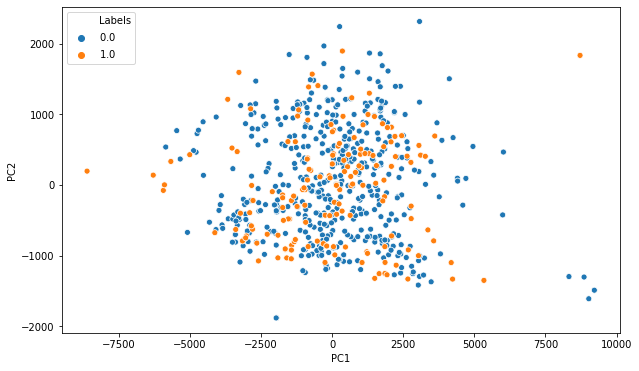

time: 297 ms


In [202]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=trans_pca['PC1'], y=trans_pca['PC2'], hue=trans_pca['Labels'])

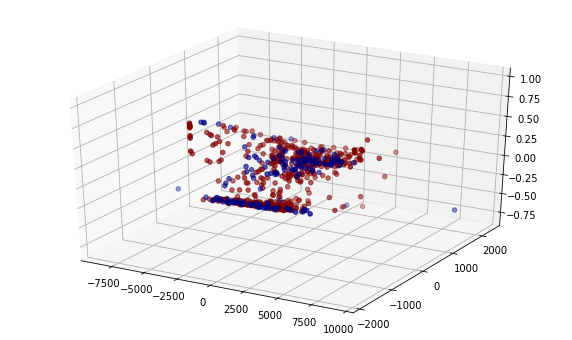

time: 197 ms


In [203]:
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection="3d")
ax.scatter3D(trans_pca['PC1'], trans_pca['PC2'], trans_pca['PC3'], c=y_test[:,0], cmap='jet_r');
plt.show()